In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits, ascii
from astropy.table import Table
from astropy.stats import sigma_clipped_stats, SigmaClip, mad_std
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS, utils
from astropy.visualization import ImageNormalize, ZScaleInterval, LinearStretch
from astropy.time import Time

from ccdproc import ImageFileCollection

import subprocess
import sys
import os
from IPython.display import clear_output

In [2]:
ls

Analisis_pruebas.ipynb     default.param            images_prop.dat  RVGru_wcs/
Astrometria_pruebas.ipynb  default.sex              mosaico.fits     Tablas/
coords.ecsv                fotometria.csv           obj.wcs          test.cat
default.conv               Fotometria_prueba.ipynb  RVGru_20190929/


In [3]:
imagen_prueba = 'RVGru_20190929/Vv0001.fit'
with fits.open(imagen_prueba) as hdul:
    hdul.info()
    hdr = hdul[0].header
    data = hdul[0].data

Filename: RVGru_20190929/Vv0001.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      71   (1024, 1024)   int16 (rescales to uint16)   


In [4]:
hdr

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                   16 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 1024 / Axis length                                    
NAXIS2  =                 1024 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
BSCALE  =           1.000000E0 / REAL = TAPE*BSCALE + BZERO                     
BZERO   =           3.276800E4 /                                                
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2019-10-04T20:22:25' / Date FITS file was generated                  
IRAF-TLM= '2019-10-04T20:24:11' / Time of last modification                     
OBJECT  = 'RVGRU   '           / Name of the object observed                    
CCDSIZE = '[1:1024,1:1024] '

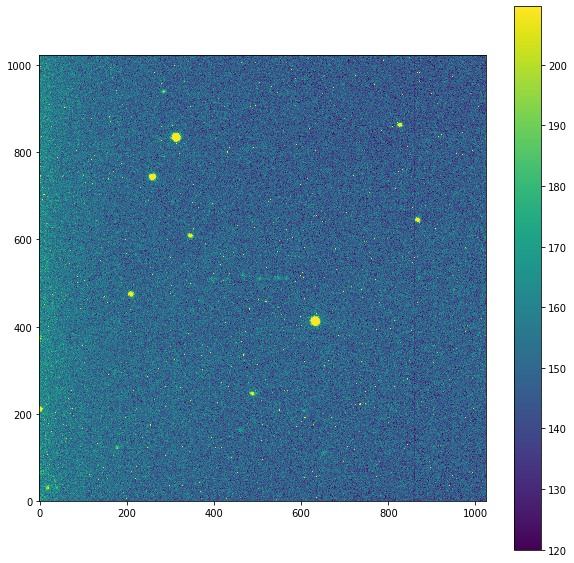

In [5]:
interval=ZScaleInterval()
vmin, vmax = interval.get_limits(data)
norm = ImageNormalize(vmin=vmin, vmax=vmax)

fig, ax = plt.subplots(figsize=(10,10))

img = ax.imshow(data, origin='lower', norm=norm) # cmap='gray'
plt.colorbar(img)
plt.show()

In [6]:
carpeta = 'RVGru_20190929/'
imagenes = ImageFileCollection(carpeta, keywords=['*'])

In [7]:
imagenes.summary['file', 'date', 'filter'][:3]

file,date,filter
str10,str19,str5
Vv0001.fit,2019-10-04T20:22:25,(3) V
Vv0002.fit,2019-10-04T20:22:25,(3) V
Vv0003.fit,2019-10-04T20:22:25,(3) V


In [8]:
def runCommand(cmd, timeout=None):
    p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    output = ''
    for line in p.stdout:
        line = line.decode(encoding=sys.stdout.encoding,
                    errors='replace' if (sys.version_info) < (3, 5)
                    else 'backslashreplace').rstrip()
        print(line)
        output += line

    retval = p.wait(timeout)
    #log.debug('retval=%d' % retval)

    return (retval)

In [9]:
encabezado = (('COMMENT' ,'Original key: "END"'), 
              ('COMMENT','--Start of Astrometry.net WCS solution--'), 
              ('COMMENT'))
pie = (('COMMENT'), ('COMMENT','--End of Astrometry.net WCS--'), 
       ('COMMENT')) 

In [10]:
stats_table=Table(names=('fname','fwhm','fwhm_std','img_mean','img_std'),
                  dtype=('a15','f','f','f','f'))

In [18]:
def Astrometria(imagenes, dir_salida, escala, n=20,forzar_escritura=False):
    '''
    Esta función agrega información asrtometríca a una serie de imágenes,
    y las guarda en una carpeta. Ademas devuelve una tabla con información
    sobre las imágenes.
    
    Parámetros 
    ----------
    imagenes: `~ccdproc.ImageFileCollection`
        Colección de las imágenes que se quiere procesar
    dir_salida: str
        Nombre del directorio de salida
    escalas: list
        Lista de las escalas [scala_low, scala_up] para dicho telescopio
    n: int    
        Número de fuentes mas brillantes utilizado para estimar el fwhm
    '''
    
    # Armo tabla de estadística    
    stats_table=Table(names=('fname','fwhm','fwhm_std','img_mean','img_std'),
                  dtype=('a15','f','f','f','f'))
    
    
    # Armo el encabezado y el pie de la nueva sección del header
    encabezado = (('COMMENT' ,'Original key: "END"'), 
              ('COMMENT','--Start of Astrometry.net WCS solution--'), 
              ('COMMENT'))
    pie = (('COMMENT'), ('COMMENT','--End of Astrometry.net WCS--'), 
           ('COMMENT')) 
    
    if forzar_escritura:
        print('Las nuevas imágenes seran guardadas en {}'.format(dir_salida))
    else:
        if os.path.exists(dir_salida):
            raise FileExistsError("Para escribir en una cerpeta existente "
                                  "usar el parametro 'forzar_escritura=True'")
        else:
            os.mkdir(dir_salida) 
            print('Se creo el directorio {}, que contendra las nuevas imágenes'.format(dir_salida))

    # Astrometry necesita valores limites de escala
    if not 0 < escala <= 1:
        raise ValueError("'escala' debe estar en el rango (0,1)")

    escala_up = str(np.ceil(escala*10)/10)
    escala_low = str(np.floor(escala*10)/10)
    
    # Itero por cada una de las imágenes en el ImageFileCollection
    for obj, fname in imagenes.hdus(imagetyp='object',return_fname=True):
        clear_output(wait=True)
        print('Buscando fuentes en imagen:', fname)

        # guardo header y data
        hder = obj.header
        data = obj.data
        
        # modifico el header para que sea fits standar
        del hder['EPOCH']
        del hder['EQUINOX']
        
        # por alguna razon el DATE-OBS no coincide con MJD-OBS para HSH
        hder['DATE-OBS']= Time(hder['MJD-OBS'], format='mjd').isot
        
        # extraigo valores de RA y DEC del header para astrometry
        img_coo = SkyCoord(hder['RA2000'], hder['DEC2000'],
                       unit=(u.hourangle, u.deg))
        ra, dec = str(img_coo.ra.degree), str(img_coo.dec.degree)
    
        # extraigo tamaño del ccd para astrometry
        width = str(hder['naxis1'])
        height = str(hder['naxis2'])
        
        # corremos sextractor -> genera test.cat (archivo binario)
        runCommand('sextractor '+imagenes.location+fname)
        coords = 'test.cat'
        t = Table.read(coords)
        rad_mean = np.mean(np.sort(t['FLUX_RADIUS'])[::-1][:n])
        rad_std = np.std(np.sort(t['FLUX_RADIUS'])[::-1][:n])
        img_mean,_,img_std = sigma_clipped_stats(data)
        stats_table.add_row([fname,rad_mean*2,rad_std*2,img_mean,img_std])
        
         
        clear_output(wait=True)
        print('Resolviendo astrometría a imagen:', fname)
    
        # corremos astrometry -> genera .wcs con info astrométrica
        runCommand('solve-field --overwrite --temp-axy \
                    --index-xyls none --solved none --match none --rdls none \
                    --corr none --no-plots --ra '+ra+' --dec '+dec+' \
                    --radius 1 --scale-units arcsecperpix --scale-low '+escala_low+' \
                    --scale-high '+escala_up+' --x-column X_IMAGE --y-column Y_IMAGE \
                    --sort-ascending --sort-column MAG_AUTO --width '+width+' --height '+height+' \
                    --wcs obj.wcs '+coords)
    
        clear_output(wait=True)
        print('Nombre de imagen:', fname)

        # armo las nuevas imágenes con la información astrometrica
        # primero abro obj.wcs y obtengo el header como una lista
        with fits.open('obj.wcs') as whdu:
            whdr = whdu[0].header
            wlist = list(dict.fromkeys(whdr))
        # agrego informacón astrométrica al header de la imagen
        # junto con encabezado y pie
        wlist.remove('DATE') # borro keyword repetido
        for enc in encabezado:
            hder.append(enc, end=True)
    
        for key in wlist[4:]:
            if key == 'HISTORY':
                for his in whdr[key]:
                    hder.append(('HISTORY',his), end=True)
            elif key == 'COMMENT':
                for com in whdr[key]:
                    hder.append(('COMMENT',com), end=True)
            else:
                hder.append((key,whdr[key],whdr.comments[key]), end=True)

        for p in pie:
            hder.append(p, end=True)

        # genero nueva imagen
        fits.writeto(dir_salida+'/'+fname[:-4]+'w.fits', data, hder, overwrite=True)

        clear_output(wait=True)

    clear_output(wait=True)
    print('Las nuevas imágenes con astrometría fueron guardadas en la carpeta {}'.format(dir_salida))
    
    # Guardo la tabla de la estadística
    stats_table.write('images_prop.dat',overwrite=True,format='ascii')

In [19]:
Astrometria(imagenes,dir_salida='RVGru_wcs',escala=0.54, forzar_escritura=True)

Las nuevas imágenes con astrometría fueron guardadas en la carpeta RVGru_wcs


In [21]:
img_prop = Table.read('images_prop.dat',format='ascii')
img_prop

fname,fwhm,fwhm_std,img_mean,img_std
str10,float64,float64,float64,float64
Vv0001.fit,8.242947578430176,0.8818293213844299,149.51683044433594,9.786988258361816
Vv0002.fit,9.319416999816895,1.8423517942428589,163.13035583496094,10.17916488647461
Vv0003.fit,9.275304794311523,1.5666587352752686,163.44015502929688,10.180580139160156
Vv0004.fit,9.693153381347656,0.5387027263641357,163.78746032714844,10.207042694091797
Vv0005.fit,8.568368911743164,1.4938238859176636,162.82373046875,10.160481452941895
Vv0006.fit,9.00232982635498,2.0317108631134033,164.07005310058594,10.160228729248047
Vv0007.fit,8.957780838012695,1.1751885414123535,162.55149841308594,10.192474365234375
Vv0008.fit,9.1056547164917,1.5495067834854126,163.3671112060547,10.152840614318848
Vv0009.fit,8.84572982788086,0.7424851059913635,162.35354614257812,10.156761169433594


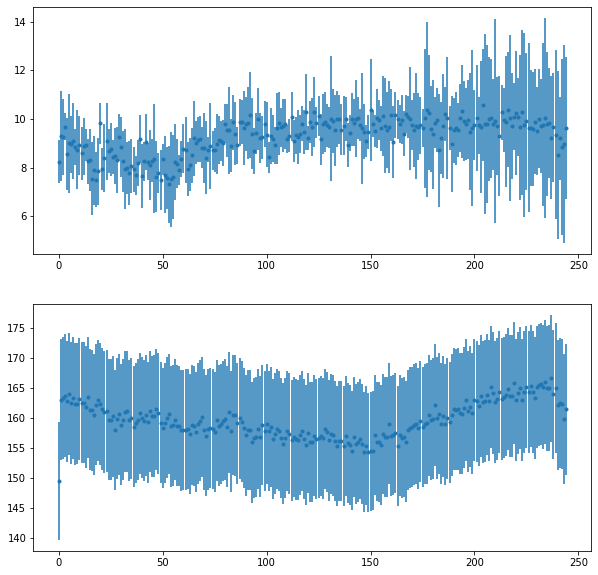

In [22]:
fig, (ax1,ax2)= plt.subplots(2,1, figsize=(10,10))
x=np.arange(0,img_prop['fname'].shape[0]) # arreglo de 0
_=ax1.errorbar(x=x,y='fwhm',
              yerr='fwhm_std',fmt='.',data=img_prop)
_=ax2.errorbar(x=x,y='img_mean',
              yerr='img_std',fmt='.',data=img_prop)

In [23]:
nueva = 'RVGru_wcs/Vv0001w.fits'
with fits.open(nueva) as hdul:
    hdul.info()
    hdr = hdul[0].header
    data = hdul[0].data
    wcs = WCS(hdr)

Filename: RVGru_wcs/Vv0001w.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     178   (1024, 1024)   int16 (rescales to uint16)   


In [24]:
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                   16 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1024                                                  
NAXIS2  =                 1024                                                  
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2019-10-04T20:22:25' / Date FITS file was generated                  
IRAF-TLM= '2019-10-04T20:24:11' / Time of last modification                     
OBJECT  = 'RVGRU   '           / Name of the object observed                    
CCDSIZE = '[1:1024,1:1024] '     / CCD size                                     
CCDSUM  = '1 1 '                 / CCD binning factors                          
PIXSIZE1=                 24.0   / pixel size for axis 1 (um)                   
PIXSIZE2=                 24

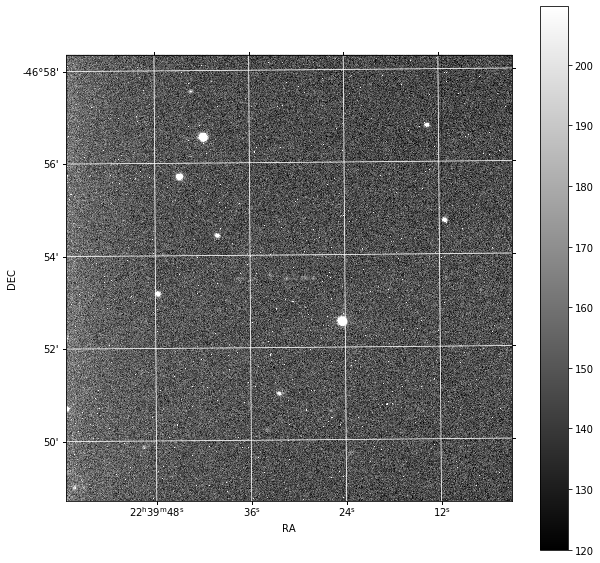

In [30]:
interval=ZScaleInterval()
vmin, vmax = interval.get_limits(data)
norm = ImageNormalize(vmin=vmin, vmax=vmax)

fig, ax = plt.subplots(figsize=(10,10))
ax = plt.subplot(projection=wcs)
img = ax.imshow(data, origin='lower', cmap='gray', norm=norm)
_ = plt.colorbar(img)
ax.grid(color='white', ls='solid')
ax.set_xlabel('RA')
ax.set_ylabel('DEC')